# Expedia Case Study - Oleg Komarov
Contact at: oleg.komarov@hotmail.it

### Overview
Understanding consumer hotel preferences and hotel pricing from a sample of hotel searches and bookings.

The following analysis mostly concentrates on consumer preferences, although still brushing the surface of the problem, and confirms a few hotel pricing stereotypes. It starts with some data due-diligence and visualization, identifies a key issue and addresses the determinants of a successful booking. It proposes some interpretations of the provided hotel features and concludes with an analysis of hotel pricing stereotypes. 

In [1]:
# Notebook tweaks
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style> code {background-color : WhiteSmoke !important;} </style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Imports (ignore warnings)
import pandas as pd
import statsmodels.api as sm
from sklearn import model_selection, linear_model, metrics
%pylab --no-import-all
%matplotlib inline

/Users/okomarov/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Import data and drop duplicates
In the next cell I import the data and drop about 12% of **duplicated records**. 

The search does not have an exact timestamp and, hence, it is safer to assume the duplicated records are **redundant**. Alternatively, assuming the searches were performed in the order they appear, duplication might indicate the customer is going back to an offer he liked. This information could provide insight about consumer preferences but this type of analysis is outside the scope of this notebook.

In [2]:
data = pd.read_csv('case_study_data.csv')
data.shape
data = data.drop_duplicates()
data.shape
data.head()

(46647, 15)

(40925, 15)

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked
0,25,457,471,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0
2,25,457,471,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0
3,25,458,463,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0
4,25,458,463,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0
5,25,458,463,2,0,1,19030,2906.65,0,59.219929,55.0,5,0,1,0


### Data cleaning
The next cell shows preliminary statistics. The dataset appears **clean**: there are no outliers nor anomalous values except for about 1000 records with `NaN`s, mostly coming from `hotel_feature_1`, which I drop.

In [3]:
desc = data.describe().loc[['min','50%','max'],:]
desc = desc.append(((data % 1 == 0) | data.isnull()).all().rename('is_whole'))
desc = desc.append(data.nunique().rename('unique'));
desc.append(data.isnull().sum().rename('countna'))

data.dropna(inplace=True);
data.shape

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked
min,0.0,0.0,1.0,1.0,0.0,0.0,1.0,30.37,0.0,2.000000,0.0,1.0,0.0,0.0,0.0
50%,12.0,110.0,118.0,2.0,1.0,4472.0,23309.0,1321.01,0.0,67.712628,52.0,46.0,4.0,1.0,0.0
max,25.0,493.0,501.0,8.0,6.0,16015.0,46647.0,175454.41,1.0,143.777606,100.0,287.0,36.0,7.0,1.0
is_whole,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
unique,23.0,436.0,452.0,8.0,7.0,16016.0,355.0,31039.00,2.0,244.000000,38.0,260.0,37.0,8.0,2.0
countna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1064.000000,297.0,0.0,0.0,0.0,0.0


(39564, 15)

As expected, `num_adults` or `num_children` are whole numbers within 0 and 8, a legit range. Also, the dummy variables `is_promo` and `booked` have two unique values, i.e. 0 and 1. Even the `hotel_price` which has a max at about \$175,454, a seemingly high value, is suggestive of a heavily leptokurtic distribution which is consistent with the shape of the income distribution. In other words, as there are very few rich individuals, so are expensive bookings. In support of this claim, the median of the `hotel_price` is $1,321, i.e. 50% of the searches got quoted at a lower price.

### Visualizing the data
The next cell plots the empirical distribution of all columns of the dataset. 

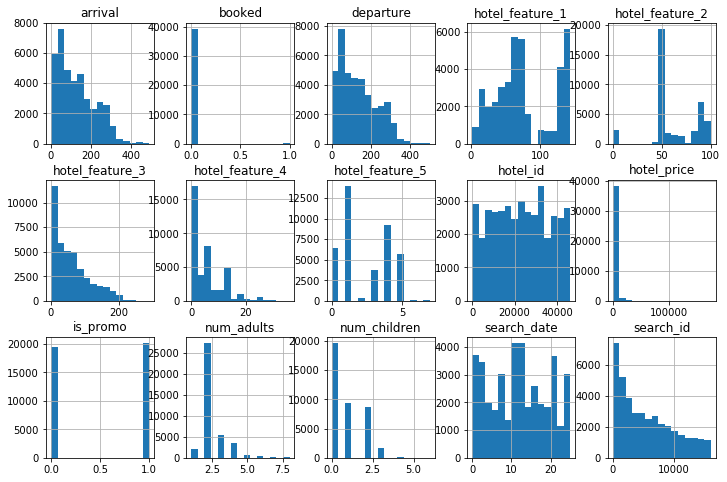

In [4]:
data.hist(bins=15,layout=(3,5), figsize=(12,8));

The graphs confirm the previous statement about the cleanliness of the dataset and offer additional insights. For instance, the distribution of `hotel_price` validates my previous statements (leptokurtic distribution). The dummy variable `is_promo` shows correctly only two values and presents almost a perfect 50-50 split. On a different note, the `booked` variable tells us that only a mere 0.71% of the searches ends up into a booking, which is likely to be a fundamental issue in the web hotel booking business. Hence I will concentrate on characterizing the following issue (a full answer is beyond the scope of this notebook):

<div class="alert alert-success">
How to maximize the booking conversion rate? 
</div>

Moreover, the histograms help us guess what the **hotel characteristics** (columns starting with `hotel_feature`) might be. Based on the ranges, the second feature might be the **recommendation score** given by previous customers while the third feature might be the number of **verified reviews**. The fifth feature could be the **property type** or the number of stars (including unrated and B&B solutions). Although it is interesting from a personal perspective to uncover what the features really are, e.g. with a conditional distribution of feature 5 on the price such that if it is monotonic, then it is most likely the number of stars, this type of analysis is not of interest (as data providers, you know what they are).  

### In-sample logistic regression
Before proceeding with the analysis of the **determinants and how they affect a booking decision** I do some additional data manipulation:
- I introduce the variable `hotels` which is the number of unique hotels per search id. Intuitively, `hotels` might proxy for the **determination** of a customer to book, since it requires more effort to look at multiple offerings, as opposed to a single query for a quick budget estimation.
- I use the logarithm of `hotel_price` to normalize its distribution.

In [5]:
data = data.join(data.groupby(data.search_id)['hotel_id'].nunique().rename('hotels'), on='search_id')
data['hotel_price'] = data['hotel_price'].transform(np.log)

To analyze what determines a booking I use the following logit model:

$$ \textrm{logit}(booked) = \beta_0 + \sum^5_{i=1} \beta_i\,feature\_i + \beta_6\,\textrm{log}(price) + \beta_7\,ispromo + \beta_8\,adults + \beta_9\,children + \beta_{10}\,hotels + error$$

The model contains hotel features, to capture customer preferences, and contextual information for the booking, e.g. number of adults or children. The model excludes the temporal variables `arrival`, `departure` and `search_date`, and the grouping variables `search_id` and `hotel_id`. 

The first group is left out from this analysis since it should be considered in a separate instance focused on seasonalities. The second group is left out since it would require panel data methodologies. This would complicate the interpretation since on one-hand we are interested in which hotel characteristics influence the booking decision but at the same time the methodology would net-out individual hotel differences. 

In [6]:
col_feat = ['hotel_feature_' + str(x) for x in range(1,6)]
col = col_feat + ['hotel_price', 'is_promo','num_adults', 'num_children','hotels']
logit = sm.Logit(data['booked'], sm.add_constant(data[col],prepend=True))
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.039535
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 booked   No. Observations:                39564
Model:                          Logit   Df Residuals:                    39553
Method:                           MLE   Df Model:                           10
Date:                Mon, 31 Jul 2017   Pseudo R-squ.:                 0.06898
Time:                        14:00:53   Log-Likelihood:                -1564.2
converged:                       True   LL-Null:                       -1680.1
                                        LLR p-value:                 3.613e-44
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.1116      0.535     -3.944      0.000      -3.161      -1.062
hotel_feature_1     0.0061      0.002      3.688      0.000       0.003       0.009
hotel_feature_2    -0.0035      0.003     -1.385      0.166      -0.008       0.001
hotel_feature_3    -0.0012      0.001     -0.819      0.413      -0.004       0.002
hotel_feature_4     0.0247      0.011      2.257      0.024       0.003       0.046
hotel_feature_5     0.0439      0.036      1.231      0.218      -0.026       0.114
hotel_price        -0.3666      0.053     -6.855      0.000      -0.471      -0.262
is_promo            0.3530      0.136      2.592      0.010       0.086       0.620
num_adults         -0.1164      0.074     -1.582      0.114      -0.261       0.028
num_children        0.0576      0.065      0.892      0.372      -0.069       0.184
hotels             -0.1790      0.024     -7.468      0.000      -0.226      -0.132
===================================================================================
"""

### The interpretation

First, the in-sample results indicate that a booking is **more likely** if price is lower and is a promotional offer, which is economically sound. Then, it appears that the **less adults** are potentially involved in the decision the higher is the probability of the booking. However, **more of kids** plays in the opposite direction, i.e. the higher their number the higher is the probability of a booking. An explanation might come from the fact that it is better to book sooner with too many kids to accommodate and kids usually have less or no impact in the decision. Also, as opposed to my initial hypothesis, the number of unique searched hotels might indicate **indecision** rather than commitment, since it has a negative impact.

In terms of hotel features, the coefficients seem to contradict the interpretation of those characteristics advanced earlier. For instance, `hotel_feature_2` which I guessed to be **customer rating** has a negative impact, while experience would suggest otherwise. However, the coefficient is insignificant and its effect might already be captured by `hotel_feature_1`, whose sign is positive. The same reasoning applies to `hotel_feature_3` (guessed to be customer reviews), unexpected sign but insignificant and potentially already captured by the first feature.

While contextual information of the search seem to have a reasonable explanation, there is work to be done on the hotel features and the selection of the optimal combination. For instance, a visual approach through a radar-like scatter favors features 1, 5 and 2, since they have superior pull when the offer is booked (labeled with 1 in the graph). 

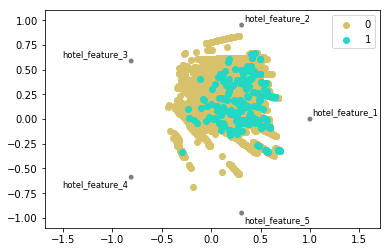

In [ ]:
pd.plotting.radviz(data[col_feat + ['booked']], 'booked');

On the other hand, the logit model suggests that `hotel_feature_2` is redundant. A closer look to how these hotel characteristics correlate among each other is warranted and proposed in the following scatter matrix.

In [ ]:
pd.plotting.scatter_matrix(data[col_feat],figsize=(10,10));

The intersection between `hotel_feature_1` and `hotel_feature_2`, row 2 vs column 1, shows no signs of correlation. The overall impression is that those features are orthogonal by construction and categorical in nature. Hence, classification methods like decision trees or at least a decomposition of variables into categorical dummies should be more appropriate than a the simple kitchen-sink regression proposed above. This recommendation does not come as a surprise and was in fact anticipated by the visualization of the empirical histograms.  

### Hotel pricing stereotypes
This section just confirms the basic stereotypes about hotel pricing, that is:
 - price depends on the length of the stay, but the cost per day diminishes as the length increases
 - booking in advance saves you money
 - these considerations are valid independent of the number of adults, children, if it is a promotion and of the hotel characteristics.

First, I derive the length of the stay from `departure` and `arrival` and add a quadratic term to capture the decreasing rate of the pricing. The number of days ahead the booking is made is derived from `arrival` and `search_date`. Finally, I dummyfy the `num_children` and `num_adults` to net out the effect of the number of people in a booking from the first two variables and to capture eventual promotional effect tied the number of people. 

In [ ]:
data['stay_len'] = data['departure'] - data['arrival']
data['stay_len2'] = data['stay_len']**2
data['days_ahead'] = data['arrival']-data['search_date']
data = pd.get_dummies(data,columns=['num_adults','num_children']);


I use a simple OLS model (no intercept to avoid perfect multicollinearity from the intercept dummies):
 
$$ price = \beta_1\,ispromo + \beta_2\,len + \beta_3\,len^2 + \beta_4\,daysahead + \sum^9_{i=5} \beta_i\,feature\_i + \sum^{16}_{i=10} \beta_i\,kids\_i + \sum^{23}_{i=17} \beta_i\,adult\_i + error$$

In [ ]:
col = (['is_promo','stay_len','stay_len2','days_ahead'] + col_feat + 
['num_children_' + str(i) for i in range(7)] + ['num_adults_' + str(i) for i in range(1,9)])
model = sm.OLS(data['hotel_price'], data[col])
result = model.fit()
result.summary()

### Interpretation
As suggested, the stereotypes are mostly confirmed:
 - the length of the stay is increasing at a decreasing rate, that is after some time, the cost per day diminishes. 
 - booking in advance supposedly saves you money, but the coefficient is insignificant and hence the effect might be weak or diluted by other variables. 

On this last point, the scatter of `days_ahead` versus `hotel_price` does show the expected decrease, if not normalized with the `log()` transformation:

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4));
data.plot.scatter('days_ahead','hotel_price',ax=ax[0]);
ax[0].set_title('log(price)');

ax[1].scatter(data.days_ahead,data.hotel_price.transform(np.exp));
ax[1].set_title('price');
ax[1].set_xlabel('days_ahead');

Additionally, as kids increase the cost increases at a decreasing rate, with a drop on 5 kids. This might suggest that big families actually look for cheaper accommodation or whole houses to rent, but additional investigation is needed. The number of adults has a strong surplus on a single person as opposed to a couple. While it is common practice to add a surcharge on a single person booking, the reason the couple actually pays less in total might be linked to promotions being offered for 2 or more adults only. 

Finally, the `num_adults_8` has more than proportionally high coefficient suggesting that data for a higher number of people might have been truncated at 8.

# Concluding remarks
Much is left to be done to answer the key issue outlined earlier, i.e. how to maximize the conversion rate. A better understanding of what determines a booking is needed, with appropriate model selection and validation (e.g. out-of sample or cross-validation), to find which variables work the best in a predictive setting. The sample could also be limited to include successful search ids only, and compare the features of the selected hotel against those with the same search id that were not picked. 

To suggest actions in order to improve the booking conversion, we also need to include a pricing recommendation, which cannot come disentangled from a through understanding of hotel pricing. As the initial analysis suggested, there are some non-monotonic irregularities that might be picking specific client segments usually overlooked (e.g. families with five kids). Choosing the appropriate price offering for those segments might prove to be the missing link.